## Expectation Maximisation for PCA

We have a prior over the latent variables $p(z) = N(z|0,I)$

We have a conditional distribution over the outputs $p(x|z) = N(x|Wz + \mu, \sigma^2 I)$

For the Expectation step...

1. We write $p(x,z) = p(x|z) p(z)$
2. $ln\;p(X,Z|\mu, W, \sigma^2) = \sum_n \left( ln\; p(x_n | z_n) p(z_n) \right)$ (we can do this summation because we assume each point is IID).
3. We want to know $E[ln\;p(X,Z | \mu, W, \sigma^2)] = E\Big[\sum_n \left[ ln\;p(x|z) + ln\;p(z) \right]\Big]$
4. We expand out these distributions and apply the log to them, to get a long expression, importantly the values that are missing that we need are $E[z_n]$ and $E[z_n z_n^\top]$. We can find these from earlier work on PCA.

using $M = W^\top W + \sigma I$

we have this expression for $p(z|x)$:

$p(z|x) = N(z|M^{-1} W^\top (x-\mu), \sigma^2 M^{-1})$

This allows us to find the values for $E[z_n]$ and $E[z_n z_n^\top]$:

$E[z_n] = M^{-1} W^\top (x-\mu)$

$E[z_n z_n^\top] = \sigma^2 M^{-1} + E[z_n]E[z_n]^\top$ (see identity proof at bottom of document)

For the Maximisation step...

We differentiated the expression for $E[ln\;p(X,Z|\mu, W, \sigma^2)]$ wrt $W$ and $\sigma^2$:

$W_{new} = \Big[\sum_n (x_n - \bar{x}) E[z_n]^\top\Big] \Big[\sum_n E[z_n z_n^\top] \Big]^{-1}$

$\sigma^2_{new} = ...$

In [413]:
#First set up our dataset, etc: A 3d dataset
import numpy as np
import matplotlib.pyplot as plt

np.set_printoptions(precision=6)
np.set_printoptions(suppress=True)
Dn = 3 #number of dimensions in the observed variables.
Mn = 1 #number of dimensions the latent variables will have (principal components)
N = 200 #number of data points

#initial values of parameters sigma^2 and the transform W (between the observed space and the latent space)
sigsqr = 1.0 #starting value of the noise variance sigma^2
W = np.random.randn(Dn,Mn) * .01 #starting value of the transform W

#data generation
x = np.random.randn(Dn,N)
x[1,:] += x[0,:]*1.5 #some covariance
x[0,:] = x[0,:] * 5.0
x[1,:] = x[1,:] * 2.0
x[2,:] -= x[1,:] * 4
x = x + np.random.randn(Dn,N) * .0

#used later for efficiency.
zeromean_x = (x.T - np.mean(x,1)).T

Plot of the data (showing each pair of dimensions)

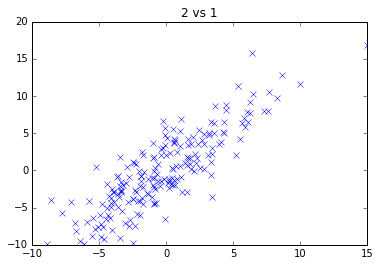

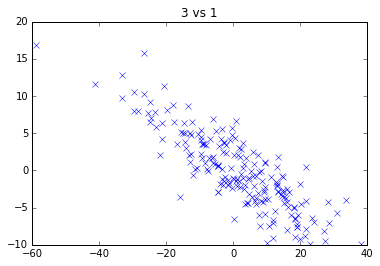

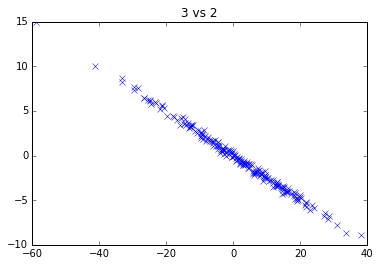

In [167]:
for d1 in range(Dn):
    for d2 in range(d1):
        plt.figure()
        plt.plot(x[d1,:],x[d2,:],'x')
        #plt.xlim([-15,15])
        #plt.ylim([-15,15])
        plt.title('%d vs %d' % (d1+1,d2+1))

The expectation maximisation

In [176]:
Ezz = []
Ez = []
for n in range(N):
    Ezz.append(np.zeros([Mn,Mn]))
    Ez.append(np.zeros(Mn)[:,None])

sig_store = []
for it in range(100):
    #Expectation, find values of components...
    M = np.dot(W.T,W) + sigsqr * np.eye(Mn)
    invM = np.linalg.inv(M) #TODO Solve using linalg.solve (MORE STABLE)
    old_Ez = Ez[:] #Use Cholesky decomp to do this inversion in a more stable way.

    for n in range(N): #TODO: Vectorise
        Ez[n] = np.dot(np.dot(invM,W.T),zeromean_x[:,n])[:,None] #MxD . Dx1 = Mx1
        Ezz[n] = sigsqr * invM + np.dot(Ez[n],Ez[n].T)
    #Maximisation 
    #Next We've differentiated E[ln p(X,Z|parameters)] and,
    #setting equal to zero, we can find what the parameters equal to maximise this    
    
    partA = np.zeros([Dn,Mn])
    for n in range(N):
        partA += np.dot(zeromean_x[:,n][:,None],Ez[n].T)
        #if n==5:
        #    print np.dot(zeromean_x[:,n][:,None],Ez[n].T)
        #    print np.dot(zeromean_x[:,n][:,None],np.dot(np.dot(invM,W.T),zeromean_x[:,n])[:,None].T)
        #    print np.dot(np.dot(zeromean_x[:,n][:,None],zeromean_x[:,n][:,None].T),np.dot(W,invM.T))
        #    print "----"

        
    partB = np.zeros([Mn,Mn])
    for n in range(N):
        partB += Ezz[n]
    new_W = np.dot(partA, np.linalg.inv(partB)) #TODO Replace inverse
    temp = 0
    for n in range(N):
        #np.linalg.norm() replace below
        temp += np.dot(zeromean_x[:,n],zeromean_x[:,n]) - 2.0*np.dot(np.dot(Ez[n].T, new_W.T),zeromean_x[:,n])
        temp += np.trace(np.dot(Ezz[n],np.dot(new_W.T,new_W)))
    new_sigsqr = (1.0/(N*Dn)) * temp #changed brackets

    sig_store.append(new_sigsqr)
   
    W = new_W.copy()
    sigsqr = new_sigsqr

print W
import matplotlib.pyplot as plt
%matplotlib inline

[[ -4.440716]
 [ -3.707295]
 [ 14.871144]]


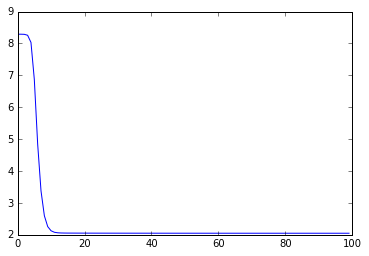

In [144]:
plt.plot(np.sqrt(sig_store))

In this plot, our predicted values (in blue x) overestimate the noise, this is because the $\sigma^2$ is large, to help explain the variance in the other dimensions that we can't explain using our model with only one dimension in the latent variable.

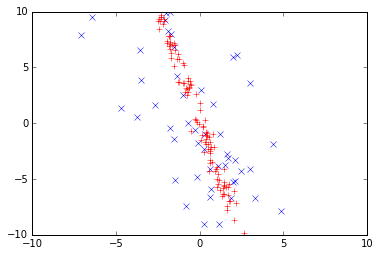

In [288]:
zs = np.random.multivariate_normal(np.zeros(Mn),np.eye(Mn),100).T
#xpred = np.dot(W,zs.T) + np.random.multivariate_normal(np.zeros(Dn),np.eye(Dn)*sigsqr,100).T
xpred = np.dot(W,zs) + np.random.multivariate_normal(np.zeros(Dn),np.eye(Dn)*sigsqr,100).T


plt.plot(xpred[1,:],xpred[2,:],'x')
plt.xlim([-10,10])
plt.ylim([-10,10])
plt.plot(x[1,:],x[2,:],'+r')

In [78]:
cov = np.dot(zeromean_x,zeromean_x.T)
#cov = np.array([[2,1],[1,2]])
u,v,w = np.linalg.svd(cov)
print w
print W
normed_W = W / np.sqrt(np.sum(W**2,0))
print normed_W.T

[[-0.301514 -0.229909 -0.925328]
 [ 0.953411 -0.062674 -0.295093]
 [ 0.00985  -0.971192  0.238094]]
[[-4.567831 -1.289641]
 [-2.076344 -2.354128]
 [-8.280469 -9.549184]]
[[-0.471783 -0.214452 -0.855238]
 [-0.130014 -0.237329 -0.96269 ]]


In [79]:
#print M
#print np.linalg.inv(M)
#print W
#print zeromean_x[:,0]
print sigsqr
print np.dot(W.T,W)
M = np.dot(W.T,W) + sigsqr * np.eye(Mn)
invM = np.linalg.inv(M)

print np.dot(np.dot(np.linalg.inv(M),W.T),zeromean_x[:,0])
print old_Ez[0]
print Ez[0]
print np.dot(np.dot(invM,W.T),zeromean_x[:,0])

[ 0.068183]
[[ 93.742447  89.850566]
 [ 89.850566  98.392017]]
[ 1.642255  1.339506]
[[ 1.642648]
 [ 1.339484]]
[[ 1.64245 ]
 [ 1.339496]]
[ 1.642255  1.339506]


In [80]:
def sqrtm(m):
    u,l,v = np.linalg.svd(m)
    for x in range(m.shape[0]):
        for y in range(m.shape[1]):
            if np.abs(m[x,y]-m[y,x])>0.001:
                print m
                raise Exception("Not diagonal")
    return np.dot(u,np.diag(np.sqrt(l)))
    #return np.dot(np.dot(u,np.diag(np.sqrt(l))),np.linalg.inv(v))
    
a = np.array([[4,2,3],[2,8,1],[3,1,5]])
b = sqrtm(a)
print b
print np.dot(b,b.T)

[[-1.522377  0.928943 -0.905226]
 [-2.359487 -1.550749  0.16733 ]
 [-1.416288  1.584967  0.694267]]
[[ 4.  2.  3.]
 [ 2.  8.  1.]
 [ 3.  1.  5.]]


In [81]:
print np.linalg.det(cov)
U,l,w = np.linalg.svd(cov)
L = np.diag(l)
print np.dot(U,sqrtm(L-sigsqr*np.eye(Mn)))
print normed_W

807352230.581


ValueError: operands could not be broadcast together with shapes (3,3) (2,2) 

Each iteration
..
We have a prior over the latent variables $p(z) = N(z|0,I)$

We have a conditional distribution over the outputs $p(x|z) = N(x|Wz + \mu, \sigma^2 I)$

For the Expectation step...

1. We write $p(x,z) = p(x|z) p(z)$
2. $ln\;p(X,Z|\mu, W, \sigma^2) = \sum_n \left( ln\; p(x_n | z_n) p(z_n) \right)$ (we can do this summation because we assume each point is IID).
3. We want to know $E[ln\;p(X,Z | \mu, W, \sigma^2)] = E\Big[\sum_n \left[ ln\;p(x|z) + ln\;p(z) \right]\Big]$
4. We expand out these distributions and apply the log to them, to get a long expression, importantly the values that are missing that we need are $E[z_n]$ and $E[z_n z_n^\top]$. We can find these from earlier work on PCA.

using $M = W^\top W + \sigma I$

we have this expression for $p(z|x)$:

$p(z|x) = N(z|M^{-1} W^\top (x-\mu), \sigma^2 M^{-1})$

This allows us to find the values for $E[z_n]$ and $E[z_n z_n^\top]$:

$E[z_n] = M^{-1} W^\top (x-\mu)$

$E[z_n z_n^\top] = \sigma^2 M^{-1} + E[z_n]E[z_n]^\top$ (see identity proof at bottom of document)

For the Maximisation step...

We differentiated the expression for $E[ln\;p(X,Z|\mu, W, \sigma^2)]$ wrt $W$ and $\sigma^2$:

$W_{new} = \Big[\sum_n (x_n - \bar{x}) E[z_n]^\top\Big] \Big[\sum_n E[z_n z_n^\top] \Big]^{-1}$

$\sigma^2_{new} = ...$

In [82]:
Ez[0]

array([[ 1.64245 ],
       [ 1.339496]])

In [83]:
Ezz[0]

array([[ 2.70342 ,  2.194783],
       [ 2.194783,  1.799754]])

### Identity $E[(a+\mu)(a+\mu)^\top] = cov(a) + \mu \mu^\top$

The final term above comes from this identity:

$E[(a+\mu)(a+\mu)^\top] = E[a a^\top] + E[a \mu^\top] + E[\mu a^\top] + E[\mu \mu^\top]$ 

We note that $E[\mu \mu^\top]=\mu \mu^\top$
and
$E[a \mu^\top]= E[a] \mu ^\top = 0$. 

Leaving just: $E[(a+\mu)(a+\mu)^\top] = E[a a^\top] + \mu \mu^\top = cov(a) + \mu \mu^\top$



In [84]:
(W/np.sqrt(np.sum(W**2,1))).T

ValueError: operands could not be broadcast together with shapes (3,2) (3,) 

In [45]:
W

array([[ 0.539039,  0.290173, -0.226545, -0.182221],
       [ 0.816748,  0.354294, -0.064329, -0.07789 ],
       [-0.58053 , -0.322487,  0.195449, -0.32974 ],
       [ 0.012254, -0.045915,  0.144265,  0.756162],
       [ 0.588898,  0.355201, -0.419885, -0.194912]])

In [46]:
np.rank(W)

/home/lionfish/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2641: VisibleDeprecationWarning: `rank` is deprecated; use the `ndim` attribute or function instead. To find the rank of a matrix see `numpy.linalg.matrix_rank`.
  VisibleDeprecationWarning)


2

In [413]:
zeromean_x

array([[ 1.991,  0.052,  0.373, -1.241, -1.174],
       [-0.75 ,  0.882,  0.016, -0.708,  0.56 ]])

In [414]:
Ez

[array([[-0.15 ],
        [-0.381]]), array([[ 0.012],
        [ 0.027]]), array([[-0.025],
        [-0.065]]), array([[ 0.073],
        [ 0.189]]), array([[ 0.091],
        [ 0.229]])]

## Online Expectation Maximisation and Differential Privacy

To summarise the aims:

 - We want users to be able to update the estimates of $W$ and $\sigma^2$. I'm currently using the EM algorithm, but this completely replaces the original values each 'iteration'. I'm trying to make each person a single iteration of the EM algorithm, but one could also sum over the people to find the two terms of $W$. The problem is that, to sum over people we have to apply a lot of noise (as they will be releasing their individual values during the summation).
 
 - We alternatively could use ML, and solve using gradients, rather than set the deriviative to zero.

### EM and people

Can I iterate through the people one at a time?

Below I try to do this, but as the number of people in the sample approach one, the algorithm fails to converge. This isn't particularly surprising.. Maybe it's the $\Big[\sum^N_{n=1} E[z_n z_n^\top] \Right]^{-1}$ inverse that gets too large?

I've dealt with it below by smoothing the change each iteration (2nd order kalman filter). It's a bit flakey and very slow but it does converge.

This doesn't seem a good solution, so below I've looked at how to do DP over the summations in the EM algorithm.

In [436]:
Ezz = []
Ez = []


N = 1 # zeromean_x.shape[1] #number of people in each group.
print N
for n in range(N):
    Ezz.append(np.zeros([Mn,Mn]))
    Ez.append(np.zeros(Mn)[:,None])

sig_store = []
indx = 0
for it in range(100000): #range(200000/N):
    x = zeromean_x[:,indx:(indx+N)]
    indx += N
    if (indx+N >= zeromean_x.shape[1]):
        indx = 0
    #x = (x.T - np.mean(x,1)).T
    
    M = np.dot(W.T,W) + sigsqr * np.eye(Mn)
    invM = np.linalg.inv(M) #TODO Solve using linalg.solve (MORE STABLE)
    old_Ez = Ez[:] #Use Cholesky decomp to do this inversion in a more stable way.

    for n in range(N): #TODO: Vectorise
        Ez[n] = np.dot(np.dot(invM,W.T),x[:,n])[:,None] #MxD . Dx1 = Mx1
        Ezz[n] = sigsqr * invM + np.dot(Ez[n],Ez[n].T)
    #Maximisation 
    #Next We've differentiated E[ln p(X,Z|parameters)] and,
    #setting equal to zero, we can find what the parameters equal to maximise this    

    partA = np.zeros([Dn,Mn])
    for n in range(N):
        partA += np.dot(x[:,n][:,None],Ez[n].T)
       
    partB = np.zeros([Mn,Mn])
    for n in range(N):
        partB += Ezz[n]
    #print partB
    new_W = np.dot(partA, np.linalg.inv(partB)) #TODO Replace inverse
    temp = 0
    for n in range(N):
        #np.linalg.norm() replace below
        temp += np.dot(x[:,n],x[:,n]) - 2.0*np.dot(np.dot(Ez[n].T, new_W.T),x[:,n])
        temp += np.trace(np.dot(Ezz[n],np.dot(new_W.T,new_W)))
    new_sigsqr = (1.0/(N*Dn)) * temp #changed brackets

    sig_store.append(new_sigsqr)
   
    W = W*0.999 + new_W.copy() * 0.001
    sigsqr = sigsqr*0.999 + new_sigsqr * 0.001

print "---"
print W
import matplotlib.pyplot as plt
%matplotlib inline

1
---
[[ 3.155545]
 [ 2.06577 ]
 [-8.653568]]


### Secure Multiparty Computation

To solve this issue, but still use batch processing:

 - Note first that $E[z_n]$ and $E[z_n z_n]$ can be calculated locally (once the mean and current estimates of $W$, $\sigma^2$ are provided).
 
We can use the locally calculated values, and add up these...
 
Steps:

 1. Find the sum of everyone's $\mathbf{x}$s. Could use Fast Mean Finder (see below)
 2. Find the mean (divide by N), $\bar{x}$
 3. Pass this and estimates of W and $\sigma^2$ to all users.
 4. Let them calculate $E[z_n]$ and $E[z_n z_n^\top]$ locally. (we could pass $M$ to save everyone needing to do computation locally).
 5. Locally find $p_1 = (x_n - \bar{x}) E[z_n]^{\top}$.
 6. Locally find $p_2 = |x_n - x|^2 - 2E[z_n]^\top W^\top_{new} (x_n - \bar{x}) + Tr(E[z_n z_n^\top] W^\top_{new} W_{new}$
 7. For $E[z_n]$, $E[z_n z_n^\top]$, $p_1$ and $p_2$ add sufficient noise to hide $x$ when added, maybe using the Fast Mean Finder (below).
 8. We now need to add up all the $p_1$s, $p_2$s and all the $E[z_n z_n^\top]$.
 9. We can now find W_{new} and \sigma^2_{new}.
 
The summations take the time, and we can choose to balance noise and accuracy using the 'fast mean finder' below.

We can also batch the users together and run the EM algorithm on a smaller number of people each time. I'm not sure if there's any advantage in this.

 - Could we combine the numbers from multiple runs of the EM algorithm...?

## Fast Mean Finder

Thinking about how Secure Multiparty computation (https://en.wikipedia.org/wiki/Secure_multi-party_computation) does adding up, it takes O(N) time and is done by person 0 adding their value to a random value r, passing this sum $s_1$ to person 1, who adds their value to this and passing $s_2$, etc. To also make this differentially private, people need to add noise proportional to the domain of their data, divided by N: $S/N$. At the end of the loop the noise will be of scale $S$

I worry how long all this takes, including finding the mean: It takes O(N) time to make it work for N people...

Instead we could have $\sqrt{N}$ loops, each with $\sqrt{N}$ people in each. We add up the output of all the loops.

So in each loop, each person adds $S/\sqrt{N}$, so the amount of noise at the end of each loop is $S\sqrt{N}$. So we've got $\sqrt{N}$ more noise than before, but the time to complete the algorithm takes only $O(\sqrt{N})$ time.

Other choices of how the loops and noise are weighted can be chosen, depending on if time or accuracy is most important.